In [2]:
#install.packages('randomForest')
library(readxl)
library(randomForest)
library(tidyverse)
#install.packages('dplyr')
library(dplyr)
library(Rcpp)


library(rpart)# Popular decision tree algorithm
#install.packages('rattle')
library(rattle)# Fancy tree plot
library(rpart.plot)# Enhanced tree plots
library(RColorBrewer)# Color selection for fancy tree plot
library(party) # Alternative decision tree algorithm
#install.packages('partykit')
library(partykit)# Convert rpart object to BinaryTree

#install.packages('tree')
library(tree)
#install.packages('multcomp')
library(multcomp)
#install.packages('party')


#install.packages('Metrics')
library(Metrics)
#install.packages('reprtree')
#devtools::install_github("MI2DataLab/randomForestExplainer")
#install.packages('randomForestExplainer')
library(randomForestExplainer)
#install.packages("scales")
library(scales)
#update.packages()
#install.packages("packagename")
require(foreign)
require(nnet)
require(ggplot2)
require(reshape2)
#install.packages("stats4")
#install.packages("splines")
library(stats4) #Load package stats
library(splines) #Load package splines
#To load package VGAM, need to load package stats4 and splines.
#install.packages("VGAM")
library(VGAM) #Load package VGAM


#install.packages("psych")
#install.packages("PerformanceAnalytics")
library(corrplot)
library(PerformanceAnalytics)
library(psych)

library(data.table)
library(writexl)



Warning message:
"package 'randomForest' was built under R version 4.0.3"
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Warning message:
"package 'tidyverse' was built under R version 4.0.5"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

Warning message:
"package 'ggplot2' was built under R version 4.0.3"
Warning message:
"package 'tidyr' was built under R version 4.0.5"
Warning message:
"package 'dplyr' was built under R version 4.0.5"
Warning message:
"package 'forcats' was built under R version 4.0.3"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::combine()  masks randomForest::combine()
x dplyr::filter()   masks stats::filter()
x dplyr::lag()      masks st

# FA (weighted) Classifcation

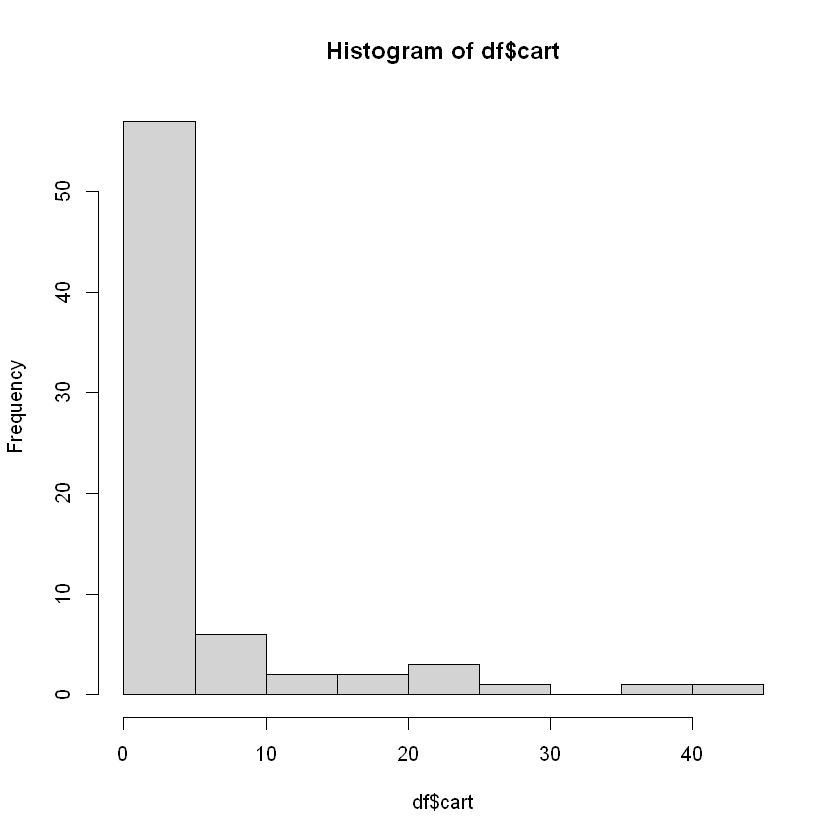

In [3]:
df.wa = read_excel( "../../results/df-water-access.xlsx" ,sheet=1)
df.exp =read_excel("../../results/df-water-explore.xlsx" ,sheet=1)
df.cluster = read_excel("../../results/df-fa-seven-cluster-rank.xlsx" ,sheet=1)
df.wb = read_excel("../../results/df-wb.xlsx" ,sheet=1 )
df.exp$clusters <- as.factor(df.cluster$clusters)
df <- merge(x = df.exp,
              y = df.wb,
              by = c("Country"))

df <- df[, c(1:13, 17,21)]

#scaling the world bank data similar to DHS aggregation out of 100
df.wb <- df[,c(9:15)]
df.wb <- data.frame(lapply(df.wb, function(x) scale(x, center = FALSE, scale = max(x, na.rm = TRUE)/100)))
df.scale <- cbind(df, df.wb)
df.scale <- df.scale[,c(1:8,15:21)]
# explanation of histogram sample of cart
df.a <- df[, c(1:6,8)]
hist(df$cart)


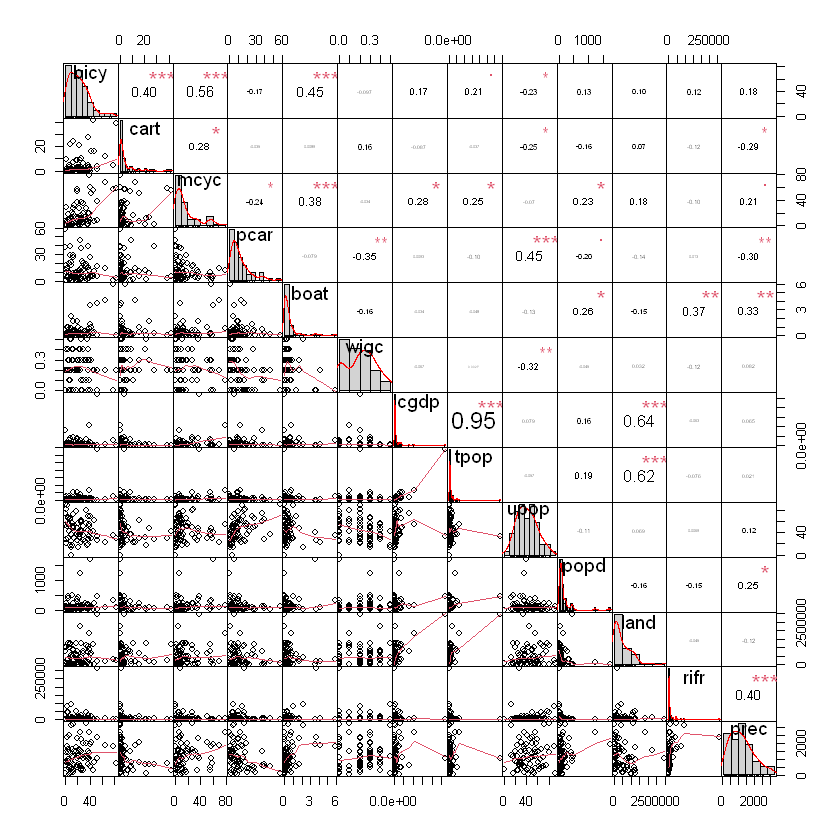

In [4]:
# explanation of the explnatory variables.
explnatory <- df[,c(2:7, 9:15)]
chart.Correlation(explnatory, histogram=TRUE, pch=19 , tl.cex = .7 )

In [5]:
#Giving unique names for the typology
# "Decentralized" , "Hybrid", "Centralized"
df <- df%>%
  mutate(clusters=case_when(
    .$clusters=="1" ~ "Decentralized",
    .$clusters=="2" ~ "Hybrid",
    .$clusters=="3" ~ "Centralized",
      ))

df.scale <- df.scale%>%
  mutate(clusters=case_when(
    .$clusters=="1" ~ "Decentralized",
    .$clusters=="2" ~ "Hybrid",
    .$clusters=="3" ~ "Centralized",
      ))

In [6]:
df$clusters <- as.factor(df$clusters)
df.scale$clusters <- as.factor(df.scale$clusters)
write_xlsx(df , '../../results/class.xlsx')
write_xlsx(df.scale , '../../results/class-scale.xlsx')
head(df)

,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,Decentralized,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,Hybrid,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,Decentralized,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,Centralized,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,Centralized,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,Hybrid,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666


# Tree

In [7]:
# Make big tree
form <- as.formula(clusters ~ . - Country)
tree.fwa <- rpart(form,data=df,control=rpart.control(minsplit=4,cp=0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4 )
                 )

par(mar=c(1,1,1,1))

pdf(file = "../../docs/manuscript/pdf-image/cp.pdf"
  ,
  width     = 5,
  height    = 5 )

plotcp(tree.fwa)

dev.off()

printcp(tree.fwa)

png 
  2


Classification tree:
rpart(formula = form, data = df, control = rpart.control(minsplit = 4, 
    cp = 0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4))

Variables actually used in tree construction:
[1] boat cgdp pcar popd prec

Root node error: 36/73 = 0.49315

n= 73 

        CP nsplit rel error  xerror    xstd
1 0.388889      0   1.00000 1.00000 0.11866
2 0.138889      1   0.61111 0.80556 0.11613
3 0.083333      2   0.47222 0.75000 0.11458
4 0.055556      3   0.38889 0.72222 0.11365
5 0.027778      4   0.33333 0.72222 0.11365
6 0.010000      6   0.27778 0.72222 0.11365


In [8]:
#size of the plot 
options(repr.plot.width=10, repr.plot.height=10)
par(mar = c(1,1,1,1))
par(cex=1)

#Interatively prune the tree
tree.pru <- prune(tree.fwa, cp=0.017) # interactively trim the tree

In [9]:
# Development of fancy plots 
pdf(file = "../../docs/manuscript/pdf-image/rpart.pdf"
  ,
  width     = 7,
  height    = 7 )

fancyRpartPlot(tree.pru, main ='', sub ='', caption='' ,palettes=c("Blues","Greens", "Reds" ))


dev.off()

summary(tree.pru)

png 
  2

Call:
rpart(formula = form, data = df, control = rpart.control(minsplit = 4, 
    cp = 0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4))
  n= 73 

          CP nsplit rel error    xerror      xstd
1 0.38888889      0 1.0000000 1.0000000 0.1186556
2 0.13888889      1 0.6111111 0.8055556 0.1161345
3 0.08333333      2 0.4722222 0.7500000 0.1145768
4 0.05555556      3 0.3888889 0.7222222 0.1136506
5 0.02777778      4 0.3333333 0.7222222 0.1136506
6 0.01000000      6 0.2777778 0.7222222 0.1136506

Variable importance
pcar cgdp popd boat prec 
  43   25   18    7    6 

Node number 1: 73 observations,    complexity param=0.3888889
  predicted class=Decentralized  expected loss=0.4931507  P(node) =1
    class counts:    22    37    14
   probabilities: 0.301 0.507 0.192 
  left son=2 (24 obs) right son=3 (49 obs)
  Primary splits:
      pcar < 12.4         to the right, improve=12.198510, (0 missing)
      wigc < 0.25         to the left,  improve= 6.923826, (0 missing)
      cgdp < 10

In [12]:
# Development of fanct variable importance plot
tree.fwa$variable.importance
var.imp  = read_excel( "../../results/variable-importance.xlsx" ,sheet=1)
s <- ggplot(var.imp , aes(x= reorder(Variable, + Importance), y= Importance)) + 
    geom_bar(stat="identity", fill="steelblue") +
    theme_minimal() +
    coord_flip() +
    theme(text = element_text(size=20))+  #Font size
        theme(axis.text.x = element_text(size=20),
          axis.text.y = element_text(size=20)) + #Adjusting the tick sizes
    xlab("")

pdf(file = "../../docs/manuscript/pdf-image/var-imp.pdf"
  ,
  width     = 14,
  height    = 7 )

par(mar=c(1,1,1,10))

s

dev.off()

pcar      cgdp      popd      boat      prec 
12.198514  7.182180  5.025910  2.065965  1.750000

png 
  2